In [1]:
import pandas as  pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import summary_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost
import shap
import lightgbm as lgb
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["figure.autolayout"]=True

/home/sam/anaconda3/envs/quant/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
raw_data = pd.read_excel('/home/sam/data/定增因子.xlsx',header=1,index_col=0)

In [3]:
def tradedays(start,end):
    # 计算两个日期间交易日数量， start、end为日期字符串
    from datetime import datetime,timedelta
    from chinese_calendar import is_holiday
    start = datetime.strptime(start,'%Y-%m-%d %H:%M:%S').date()
    end = datetime.strptime(end,'%Y-%m-%d %H:%M:%S').date()
    if start > end:
        start,end = end,start
    counts = 0
    while True:
        if start > end:
            break
        if is_holiday(start) or start.weekday()==5 or start.weekday()==6:
            start += timedelta(days=1)
            continue
        counts += 1
        start += timedelta(days=1)
    return counts

In [4]:
x = raw_data[['发行日期','限售股份解禁日']].applymap(str)

In [5]:
raw_data['持有交易日'] = x.apply(lambda a:tradedays(a['发行日期'], a['限售股份解禁日']), axis=1)

In [6]:
# 计算年化收益率
raw_data['年化收益率'] = raw_data['解禁日绝对收益']/raw_data['持有交易日']*252

In [ ]:
raw_data1 = raw_data[:1100].copy()
raw_data2 = raw_data[1100:1540].copy()
raw_data3 = raw_data[1540:].copy()

In [ ]:
raw_data_before_2020 = raw_data[:1540].copy()
raw_data_after_2020 = raw_data[1540:].copy()

In [11]:
raw_data['发行日期'] = raw_data['发行日期'].astype(np.string_)
raw_data['发行月份'] = raw_data['发行日期'].apply(lambda x:x[5:7])
raw_data['发行月份'] = raw_data['发行月份'].astype('category')
raw_data['所属行业'] = raw_data['所属行业'].astype('category')

In [ ]:
raw_data_before_2020['发行日期'] = raw_data_before_2020['发行日期'].astype(np.string_)
raw_data_before_2020['发行月份'] = raw_data_before_2020['发行日期'].apply(lambda x:x[5:7])
raw_data_after_2020['发行日期'] = raw_data_after_2020['发行日期'].astype(np.string_)
raw_data_after_2020['发行月份'] = raw_data_after_2020['发行日期'].apply(lambda x:x[5:7])

In [17]:
QUANT_FACTOR = ['发行价格','预计募资','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值']
CLASS_FACTOR = ['发行月份', '所属行业']
RETURN = ['年化收益率']

In [13]:
def preprocess(raw_data,QUANT_FACTOR, RETURN, CLASS_FACTOR):
    dataset = raw_data[QUANT_FACTOR+RETURN+CLASS_FACTOR].copy()
    dataset.replace('-', np.nan, inplace=True)
    data = dataset.dropna(axis=0)
    quant_factor = standardization(data[QUANT_FACTOR])
    return_metric = standardization(data[RETURN])
    class_label = data[CLASS_FACTOR].copy()
    #quant_factor = market_value_neutralization(quant_factor)
    #quant_factor = schmit_orthogonalization(quant_factor)
    #onehot = onehot_encoder(data[CLASS_FACTOR])
    #obj_data = data['发行对象'].apply(obj_string_to_value)
    preprocessed_data = pd.concat([quant_factor, return_metric, class_label], axis=1)
    cond = (preprocessed_data[QUANT_FACTOR+RETURN] < -3) | (preprocessed_data[QUANT_FACTOR+RETURN] > 3)
    preprocessed_data[RETURN+QUANT_FACTOR].mask(cond, inplace=True)
    #for r in RETURN_NAME+QUANT_FACTOR:
        #preprocessed_data = preprocessed_data[(preprocessed_data[r] > -3) & (preprocessed_data[r] < 3)]
    return preprocessed_data

#标准化为Z_score
def standardization(quant_col_data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    quant_factor = pd.DataFrame(scaler.fit_transform(quant_col_data),columns=quant_col_data.columns)
    quant_factor.set_index(quant_col_data.index, inplace=True)
    return quant_factor

#定量因子的市值中性化
#有schmit正交化好像不用中性化
def market_value_neutralization(quant_factor):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X = quant_factor['总市值'].values.reshape(-1, 1)
    for f in quant_factor.columns:
        y = quant_factor[f]
        lr.fit(X, y)
        y_pred = lr.predict(X)
        quant_factor[f] = y - y_pred
    quant_factor.drop(['总市值'], axis=1, inplace=True)
    QUANT_FACTOR.remove('总市值')
    return quant_factor

def onehot_encoder(class_col_data):
    onehot = pd.get_dummies(class_col_data.loc[:,CLASS_FACTOR], prefix_sep="", columns=CLASS_FACTOR)
    return onehot

In [15]:
df = preprocess(raw_data,QUANT_FACTOR, RETURN,CLASS_FACTOR)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df1 = preprocess(raw_data1,QUANT_FACTOR, RETURN,CLASS_FACTOR)
df2 = preprocess(raw_data2,QUANT_FACTOR, RETURN,CLASS_FACTOR)
df3 = preprocess(raw_data3,QUANT_FACTOR, RETURN,CLASS_FACTOR)

In [ ]:
data_before_2020 = preprocess(raw_data_before_2020, QUANT_FACTOR, RETURN,CLASS_FACTOR)
data_after_2020 = preprocess(raw_data_after_2020, QUANT_FACTOR, RETURN, CLASS_FACTOR)
#preprocessed_data.to_csv('preprocessed_data.csv', index=True)

In [ ]:
df.to_csv('clean_continuous_data.csv', index=True)
df1.to_csv('clean_continuous_data_2011_2017.csv', index=True)
df2.to_csv('clean_continuous_data_2017_2020.csv', index=True)
df3.to_csv('clean_continuous_data_2020_today.csv', index=True)

In [ ]:
data_before_2020.to_csv('data_before_2020.csv')
data_after_2020.to_csv('data_after_2020.csv')

In [ ]:
#读取干净数据
QUANT_FACTOR = ['发行价格','预计募资','折扣率','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
            '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位','闪发','净利FY1','净利FY2','总市值']
RETURN = ['年化收益率']
CLASS_FACTOR = ['发行月份', '所属行业']

In [ ]:
df1 = pd.read_csv('clean_continuous_data_2011_2017.csv', index_col=0, header=0)
df2 = pd.read_csv('clean_continuous_data_2017_2020.csv', index_col=0, header=0)
df3 = pd.read_csv('clean_continuous_data_2020_today.csv', index_col=0, header=0)

In [ ]:
N = 20
quantile_tmp = pd.qcut(df['年化收益率'],N,labels=np.arange(0,N)) 
quantile_mean = df.groupby(quantile_tmp).mean()

fig, ax =plt.subplots(len(QUANT_FACTOR),1, constrained_layout=True, figsize=(9, 20))
for i in range(len(QUANT_FACTOR)):
    axesSub = sns.lineplot(data=quantile_mean[QUANT_FACTOR[i]], legend='brief', ax=ax[i])

In [ ]:
fig, ax =plt.subplots(3,1, constrained_layout=True, figsize=(9, 13))
factor_list = ['折扣率', '增发占增发后自由流通市值', '发行前20日股价涨跌幅', '行业20日涨跌幅',  '基金占比']
for i in range(len(factor_list)):
    axesSub = sns.lineplot(data=quantile_mean[factor_list[i]], legend='brief', ax=ax[i])

In [ ]:
factor_list = ['折扣率', '发行前20日股价涨跌幅', '行业20日涨跌幅',  '基金占比']

In [ ]:
sns.lineplot(data=quantile_mean[factor_list], legend='brief')

# 相关性分析

The input array could not be properly checked for nan values. nan values will be ignored.


<AxesSubplot:>

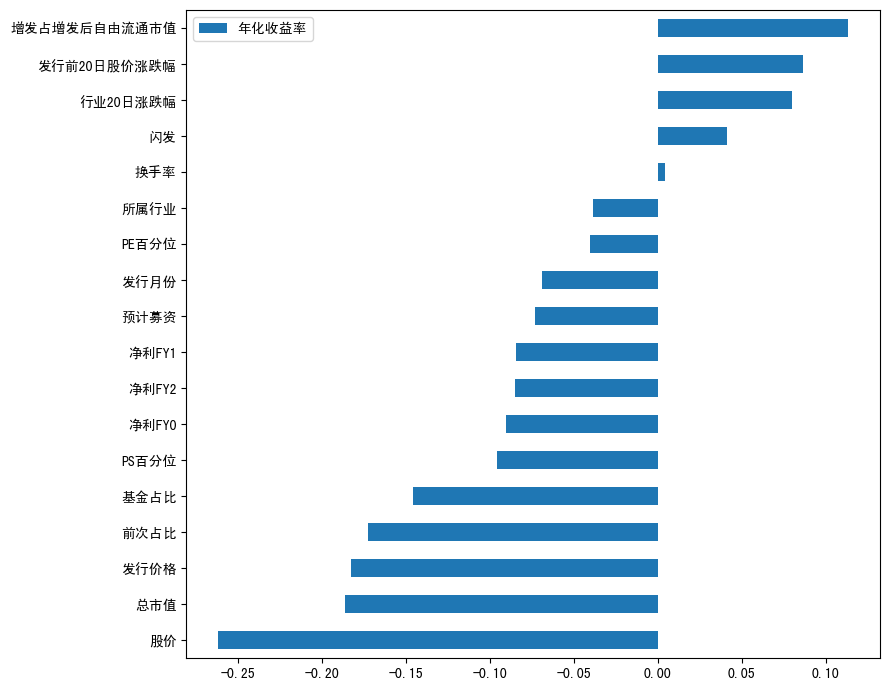

In [18]:
factor_corr = list()
for f in QUANT_FACTOR+CLASS_FACTOR:
    c = df[f].corr(df['年化收益率'],method='spearman')
    factor_corr.append(c)
corr_df = pd.DataFrame(np.asarray(factor_corr), index=QUANT_FACTOR+CLASS_FACTOR, columns=['年化收益率'])
corr_df.sort_values(by=['年化收益率'],inplace=True)
corr_df.plot(kind='barh', figsize=(9, 7))

In [ ]:
#施密特正交化
def schmit_orthogonalization(quant_factor):
    M = (quant_factor.shape[0]-1)*np.cov(quant_factor.T.astype(float))
    D,U = np.linalg.eig(M)
    U = np.mat(U)
    d = np.mat(np.diag(D**(-0.5)))
    S = U*d*U.T
    ortho_factor_mat = np.mat(quant_factor)*S
    ortho_factor = pd.DataFrame(ortho_factor_mat, columns=quant_factor.columns,index = quant_factor.index)
    return ortho_factor

In [ ]:
# 线性回归因子重要性分析
cols = ['发行价格','预计募资','折扣率','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值', '年化收益率']

# 机器学习模型的训练集与预测集划分
y = df['年化收益率']
cols.pop()
X = df[cols]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [ ]:
X = sm.add_constant(X)
linear_model = sm.OLS(y, X)
linear_model.fit().summary()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)
model.score(X_test,y_test)

In [ ]:
mean_pred = pd.Series([np.mean(y_train)]*y_test.shape[0])

In [ ]:
rand_pred = pd.Series(np.random.randn(y_test.shape[0]))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
print('MSE of mean prediction and true values:{0:.3f}'.format(mean_squared_error(mean_pred, y_test)))
print('MSE of random prediction and true values:{0:.3f}'.format(mean_squared_error(rand_pred, y_test)))
print('MSE of DT prediction and true values:{0:.3f}'.format(mean_squared_error(y_pred, y_test)))

In [ ]:
# 线性回归因子重要性分析
cols = ['发行价格','预计募资','折扣率','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值', '年化收益率']
# 机器学习模型的训练集与预测集划分
y = df3['年化收益率']
cols.pop()
X = df3[cols]

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=0)
model.fit(X, y)

In [ ]:
N_fold = 10
importances = np.zeros((17,))
for i in range(N_fold):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    model.fit(X_train, y_train)
    importances = model.feature_importances_ + importances
importances = importances/N_fold

indices = np.argsort(importances)
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X.columns)[indices])

In [ ]:
# 线性回归因子重要性分析
cols = ['发行价格','预计募资','折扣率','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值', '年化收益率']
# 机器学习模型的训练集与预测集划分
y = df['年化收益率']
cols.pop()
X = df[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'task': 'train',
    'boosting_type': 'goss',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    #'bagging_fraction': 0.8,  # 建树的样本采样比例
    #'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 0  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
my_model = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, early_stopping_rounds=5)
predictions = my_model.predict(X_test, num_iteration=my_model.best_iteration)
print("Mean Absolute Error : " + str(mean_squared_error(predictions, y_test)))

In [ ]:
print("Mean Absolute Error of rand prediction: " + str(mean_squared_error(rand_pred, y_test)))
mean_pred = mean_pred = pd.Series([np.mean(y_train)]*y_test.shape[0])
print("Mean Absolute Error of mean prediction: " + str(mean_squared_error(mean_pred, y_test)))

In [ ]:
# 线性回归因子重要性分析
cols = ['发行价格','预计募资','折扣率','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值', '年化收益率']
# 机器学习模型的训练集与预测集划分
y = df3['年化收益率']
cols.pop()
X = df3[cols]
N_fold = 10
params = {
    'task': 'train',
    'boosting_type': 'goss',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    #'bagging_fraction': 0.8,  # 建树的样本采样比例
    #'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': -1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
importances = np.zeros((17,))
for i in range(N_fold):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    my_model = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, early_stopping_rounds=5)
    importances = my_model.feature_importance() + importances
importances = importances/N_fold

indices = np.argsort(importances)
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X.columns)[indices])

## Shapley重要性

In [ ]:
# 线性回归因子重要性分析
cols = ['发行价格','预计募资','折扣率','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值', '年化收益率']
# 机器学习模型的训练集与预测集划分
y = df3['年化收益率']
cols.pop()
X = df3[cols]
params = {
    'task': 'train',
    'boosting_type': 'goss',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    #'bagging_fraction': 0.8,  # 建树的样本采样比例
    #'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': -1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
my_model = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, early_stopping_rounds=5)
explainer = shap.Explainer(my_model)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

# 交换重要性

In [26]:
QUANT_FACTOR = ['发行价格','预计募资','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值', '年化收益率']
CLASS_FACTOR = ['发行月份', '所属行业']

In [28]:
y = df['年化收益率']
X = df[QUANT_FACTOR+CLASS_FACTOR]
params = {
    'task': 'train',
    'boosting_type': 'goss',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'verbose': -1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
model = lgb.train(params, lgb_train, num_boost_round=270, valid_sets=[lgb_eval], early_stopping_rounds=5)

[1]	valid_0's auc: 1	valid_0's l2: 0.81989
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 1	valid_0's l2: 0.746376
[3]	valid_0's auc: 1	valid_0's l2: 0.680607
[4]	valid_0's auc: 1	valid_0's l2: 0.619535
[5]	valid_0's auc: 1	valid_0's l2: 0.564307
[6]	valid_0's auc: 1	valid_0's l2: 0.516262
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's l2: 0.81989


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


In [29]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)
    
    y_pred = model.predict(X_permuted)
    permuted_score = r2_score(y_pred, y)
    #permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """
    y_pred = model.predict(X)
    baseline_score_train = r2_score(y_pred, y)
    #baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

In [30]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""
    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

In [ ]:
perm_importance_result_train = permutation_importance(model, X_train, y_train, n_repeats=10)

plot_feature_importances(perm_importance_result_train, X_train.columns)

# 二分类预测

In [ ]:
from sklearn.metrics import auc, f1_score, roc_auc_score, roc_curve, accuracy_score, recall_score

In [ ]:
QUANT_FACTOR = ['发行价格','预计募资','增发占增发后自由流通市值','发行前20日股价涨跌幅',\
                '行业20日涨跌幅','股价','基金占比','前次占比','换手率','净利FY0','PS百分位','PE百分位',\
                '闪发','净利FY1','净利FY2','总市值']
CLASS_FACTOR = ['发行月份', '所属行业']

In [ ]:
data_before_2020 = pd.read_csv('data_before_2020.csv', index_col=0)
data_after_2020 = pd.read_csv('data_after_2020.csv',index_col=0)

data_before_2020['盈利']= data_before_2020['年化收益率'].apply(lambda x : 1 if x>0 else 0)
data_after_2020['盈利']= data_after_2020['年化收益率'].apply(lambda x : 1 if x>0 else 0)
data_before_2020[CLASS_FACTOR] = data_before_2020[CLASS_FACTOR].astype('category')
data_after_2020[CLASS_FACTOR] = data_after_2020[CLASS_FACTOR].astype('category')

In [ ]:
factors = QUANT_FACTOR# + CLASS_FACTOR
y_test = data_after_2020['盈利']
X_test = data_after_2020[factors]
X = data_before_2020[factors]
y = data_before_2020['盈利']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

lgbclf = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, learning_rate=0.05, n_estimators=270,\
                            max_bin=255, objective='binary', colsample_bytree=0.9, n_jobs=4)

lgbclf.fit(X_train, y_train, eval_set=(X_valid, y_valid),eval_metric='logloss',\
           early_stopping_rounds=5, verbose=False)
y_pred = lgbclf.predict_proba(X_test)[:, 1]
y_pred_label = np.array([1 if x > 0.5 else 0 for x in y_pred])

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print('auc:'+str(auc(fpr, tpr)))
print('accuracy:'+str(accuracy_score(y_pred_label, y_test)))
print('recall:'+str(recall_score(y_pred_label, y_test)))
print('f1_score:'+str(f1_score(y_pred_label, y_test)))

In [ ]:
factors = QUANT_FACTOR# + ['折扣率']
y_test = data_after_2020['年化收益率']
X_test = data_after_2020[factors]
X = data_before_2020[factors]
y = data_before_2020['年化收益率']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

lgbrgs = lgb.LGBMRegressor(boosting_type='goss', max_depth=5, learning_rate=0.05, n_estimators=270,\
                            max_bin=255, objective='regression', colsample_bytree=0.9, n_jobs=4)

lgbrgs.fit(X_train, y_train, eval_set=(X_valid, y_valid),eval_metric='l2',\
           early_stopping_rounds=5, verbose=False)
explainer = shap.Explainer(lgbrgs)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

# 类因子的单方差分析

In [ ]:

RAW_DATA_PATH = '/home/sam/data/定增因子.xlsx'
raw_data = pd.read_excel(RAW_DATA_PATH,header=1,index_col=0)
anova_df = raw_data[['增发目的', '大股东是否跟投','盈利预测']]
return_df = pd.read_csv('clean_continuous_data.csv', index_col=0, header=0)['年化收益率']

anova_df = anova_df.join(return_df, how='right')

mod = ols('年化收益率 ~ 盈利预测+大股东是否跟投+增发目的', data=anova_df).fit()
table = sm.stats.anova_lm(mod, typ=2) # Type 2 Anova DataFrame
print(table)